In [0]:
%pip install -i https://pypi.ap.burberry.com sd-data
%pip install holidays==0.24
%pip install prophet==1.1.2

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Looking in indexes: https://pypi.ap.burberry.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 41.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.27.1
    Not uninstalling holidays at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2e74f8af-4756-4212-af43-52518c074b92
    Can't uninstall 'holidays'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [0]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [0]:
import pandas as pd
import numpy as np
#import networkx as nx
import seaborn as sns
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank, col
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pyspark import SQLContext
import pyspark.sql
import pyspark.sql.functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sts
import statistics as st
from numpy import mean, std, absolute
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.validation import check_consistent_length, check_array
from sklearn.decomposition import PCA

# from tslearn.clustering import TimeSeriesKMeans, silhouette_score
# from tslearn.datasets import CachedDatasets
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from datetime import datetime, timedelta, date
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import random
import logging


import sd_data
from sd_data import Transactions, Products, Footfall

from sd_data.transformers.core import (
    pipeline,
    add_copy,
    add_coalesce,
    add_date,
    add_translation,
    add_cast,
    add_join,
    add_material,
    add_bool_from_match,
    add_fixed_column,
    apply_fillna,
    apply_filter,
    apply_sort,
    apply_select,
    apply_distinct,
    group_first,
    group_agg,
)

hyperparameter_tuning = False
random_treatment_test = False
prios_tuning = False
normal_run = True

logging.getLogger("py4j").setLevel(logging.ERROR)

spark.conf.set("spark.sql.execution.arrow.enabled", "false")
pd.set_option("display.float_format", lambda x: "%.1f" % x)

In [0]:
dbutils.widgets.removeAll()

In [0]:

# #pilots when aggregated are summed, so rates where we need average of the pilots will not work
# dbutils.widgets.text("data_table", "platform.supply_chain_analytics.rabit_data_current")
# dbutils.widgets.text("date_column", "order_date")
# dbutils.widgets.text("date_format", "%Y-%m-%d")
# dbutils.widgets.text("control_column", "alt_level_3")
# dbutils.widgets.text("treatment_values", "M TOPS")
# dbutils.widgets.text("control_pool_column", "store_region")
# dbutils.widgets.text("control_pool_values", "EMEIA")
# dbutils.widgets.text("kpi_column", "actualsalesamt_central")
# dbutils.widgets.text("feature_selection", "5")
# dbutils.widgets.text("top_n_percent_largest_controls", "0.5")

# dbutils.widgets.text("train_start", "2017-01-01")
# dbutils.widgets.text("train_end", "2019-06-01")
# dbutils.widgets.text("test_start", "2019-06-02")
# dbutils.widgets.text("test_end", "2019-12-31")
# dbutils.widgets.text("treatment_start", "2019-06-02")
# dbutils.widgets.text("treatment_end", "2019-12-31")

# dbutils.widgets.text("significance_value", "0.9")
# dbutils.widgets.text("change_points", "2019-12-31|2020-03-01")
# dbutils.widgets.text("remove_controls_containing", "bag|hat")
# dbutils.widgets.text("daily_weekly_aggregation", "daily")
# dbutils.widgets.text("length_of_training_output", "30")
# dbutils.widgets.text("clip_dates", "")
#CLIP DATES IS HIGHLIGHTED OUT DOWN IN THE CODE BELOW, REACTIVATE IF WANT TO USE

In [0]:
traffic_params_dictionary = {
    "data_table": "user.ahutt.harrods_data_mainline",
    "date_column": "order_date",
    "date_format": "%Y-%m-%d",
    "control_column": "store_no",
    "treatment_values": "1316|1325|2578|1300|1335",
    "control_pool_column": "store_region",
    "control_pool_values": "EMEIA",
    "kpi_column": "gross_revenue",
    "impute_stores":"1210",
    "feature_selection": "6",
    "force_controls": "",
    "top_n_percent_largest_controls": "0.25",
    "train_start": "2021-04-01",
    "train_end": "2024-01-31",
    "test_start": "2024-02-01",
    "test_end": "2024-02-29",
    "treatment_start": "2024-02-01",
    "treatment_end": "2024-02-29",
    "significance_value": "0.975",
    "change_points": "2023-08-01",
    "remove_controls_containing": "1010|1243|1000|1128|1291|1332|1289|1368|1009|1214|1020|1370", #1370 bad control
    "daily_weekly_aggregation": "daily",
    "length_of_training_output": "750",
    "clip_dates": "",
    "hyperparam_tune_bool":"True"
}
for key, value in traffic_params_dictionary.items():
    dbutils.widgets.text(key, value, key)

In [0]:
get_data_table = spark.table(dbutils.widgets.get("data_table"))
get_date_column = dbutils.widgets.get("date_column")
get_date_format = dbutils.widgets.get("date_format")
get_control_column = dbutils.widgets.get("control_column")
get_treatment_values = [str(store) for store in dbutils.widgets.get("treatment_values").split('|')]
get_control_pool_column = dbutils.widgets.get("control_pool_column")
get_control_pool_values = dbutils.widgets.get("control_pool_values").split('|')
get_kpi_column = dbutils.widgets.get("kpi_column")
get_impute_stores = dbutils.widgets.get("impute_stores").split('|')
get_feature_selection = int(dbutils.widgets.get("feature_selection"))
get_force_controls = dbutils.widgets.get("force_controls").split('|')
get_top_n_percent_largest_controls = float(dbutils.widgets.get("top_n_percent_largest_controls"))
get_hyperparam_tune_bool = dbutils.widgets.get("hyperparam_tune_bool")

get_train_start = datetime.strptime(dbutils.widgets.get("train_start"), get_date_format)
get_train_end = datetime.strptime(dbutils.widgets.get("train_end"), get_date_format)
get_test_start = datetime.strptime(dbutils.widgets.get("test_start"), get_date_format)
get_test_end = datetime.strptime(dbutils.widgets.get("test_end"), get_date_format)
get_treatment_start = datetime.strptime(dbutils.widgets.get("treatment_start"), get_date_format)
get_treatment_end = datetime.strptime(dbutils.widgets.get("treatment_end"), get_date_format)

get_significance_value = float(dbutils.widgets.get("significance_value"))
get_change_points = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("change_points").split('|')]
get_remove_controls_containing = dbutils.widgets.get("remove_controls_containing").split('|')
get_daily_weekly_aggregation = dbutils.widgets.get("daily_weekly_aggregation")
get_length_of_training_output = int(dbutils.widgets.get("length_of_training_output"))
#get_clip_dates = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("clip_dates").split('|')]

In [0]:
def remove_stores_containing_phrases(df_stores, remove_stores_containing, variable):
    if variable in df_stores.columns:
        if type(remove_stores_containing) == list:
            # remove stores with name containing any of these strings i.e. " MW" or " CW" Menswear Childrenswear
            init_stores = df_stores.select(variable).distinct().count()
            for cutword in remove_stores_containing:
                print(f"trying to remove {cutword}")
                df_stores = df_stores.withColumn(
                    "contains_phrase",
                    f.when(f.col(variable).contains(cutword), True).otherwise(False),
                ).filter(f.col("contains_phrase") == False)
            stores_dropped = init_stores - df_stores.select(variable).distinct().count()
            print(f"Stores Cut by {variable}: {stores_dropped}/{init_stores}")
    else:
        pass
    return df_stores
  
def convert_dates_to_datetime(sdf, date_col, date_format):
    return sdf.withColumn(date_col, f.to_date(date_col, format=date_format))
  
def filter_top_n_largest_control_candidates(sdf, control_col, kpi_col, treatment_values, n_percent):
    window = Window.orderBy(f.col(f"{kpi_col}_size").desc())

    mean_stores = (
        sdf.filter(f.col(kpi_col).isNotNull()).filter(f.col(kpi_col) > 0).groupBy(control_col)
        .agg(f.mean(kpi_col).alias(f"{kpi_col}_size"))
        .orderBy(f.col(f"{kpi_col}_size").desc())
    ).withColumn("row_number", f.row_number().over(window))

    # Filter the DataFrame to keep the top half and rows with store_no in treatment_values
    mean_stores_filtered = mean_stores.filter(
        (f.col("row_number") <= mean_stores.count() * n_percent) |
        (f.col(control_col).isin(treatment_values))
    ).drop("row_number")

    total_controls, filtered_controls = mean_stores.select(control_col).distinct().count(), mean_stores_filtered.select(control_col).distinct().count()

    print(f"Filter Largest Controls: {total_controls} --> {filtered_controls}")

    return sdf.join(mean_stores_filtered, control_col, "inner")

def keep_top_n_percent_of_controls(sdf, relative_size_col, n_percent):
  return sdf.filter(f.col(relative_size_col)>f.col(relative_size_col))

def aggregate_pilot_stores(sdf, treated_values, control_col, date_col, kpi_col):
    # use all days of that week from all years to determine a median benchmark to compare footfall against

    print(treated_values)
    
    sdf = sdf.withColumn(
        "treated_values_and_controls",
        f.when(f.col(control_col).isin(treated_values), "Agg_Pilot_Stores").otherwise(
            f.col(control_col)
        ),
    )

    if "store_name" in sdf.columns:
        treatment_stores_included = [i[0] for i in sdf.filter(f.col("treated_values_and_controls")=='Agg_Pilot_Stores').select("store_name").distinct().collect()]

        print(f"Treatment Stores Included {treatment_stores_included}")

    return sdf.groupby([f.col("treated_values_and_controls").alias(control_col), date_col]).agg(f.sum(kpi_col).alias(kpi_col))
  
def pivot_control_values(sdf, output_cols, input_cols, group_cols, pivot_col, functions_list):
  return sdf.groupby(group_cols).pivot(pivot_col).agg(*[func(input_col).alias(output_col) for output_col, input_col, func in zip(output_cols,input_cols, functions_list)])

def remove_candidates_with_excessive_zero_days_in_treatment(sdf, threshold, control_col, kpi_col, treatment_values, treatment_start, treatment_end):
    #removes all columns with many days in the treatment period that are zero
    #threshold is 0->1 i.e 0.7 means at least 70% of treatment period is non null
    window = Window.partitionBy().orderBy(f.col(f"{kpi_col}_size").desc())

    length_of_treatment = (treatment_end - treatment_start).days

    sdf_treatment = sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))

    non_null_stores = (
    sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))
    .filter(f.col(kpi_col).isNotNull())
    .filter(f.col(kpi_col) > 0)
    .groupby(control_col)
    .agg(f.count(kpi_col).alias(f"{kpi_col}_not_zero"))
    .withColumn("non_null_days", f.col(f"{kpi_col}_not_zero") / length_of_treatment)
    ).filter(
        (f.col("non_null_days") >= -1) | (f.col(control_col).isin(treatment_values))
    )

    total_controls, filtered_controls = (
        sdf.select(control_col).distinct().count(),
        non_null_stores.select(control_col).distinct().count(),
    )

    print(
        f"Filter Non-Active in Treatment Controls: {total_controls}-->{filtered_controls}"
    )
    
    return sdf.join(non_null_stores, control_col, "inner")

def add_store_closure_index(df_pilot_daily_df, data):
    store_closure = df_pilot_daily_df.rename(columns={"order_date": "ds"}).query(
        "store_no=='Agg_Pilot_Stores'"
    )
    data = (
        data.merge(
            store_closure[["ds", "weighted_footfall_percentage", "store_size"]],
            on="ds",
            how="left",
        )
        .rename(columns={"weighted_footfall_percentage": "store_closure"})
        .fillna(0)
    )
    return data
  
def get_best_params_for_preset(preset_params, change_points):
    if type(preset_params) == list:
        # if hyper param tuning is false and list given to preset params, then use the presets
        (
            changepoint_prior_preset,
            changepoint_range_preset,
            seasonality_prior_preset,
            seasonality_mode_preset,
        ) = (preset_params[0], preset_params[1], preset_params[2], preset_params[3])
        if type(change_points) == list:
            # if list given to change points then add change points
            best_params = {
                "seasonality_mode": seasonality_mode_preset,
                "seasonality_prior_scale": seasonality_prior_preset,
                "changepoint_prior_scale": changepoint_prior_preset,
                "changepoints": change_points,
                "changepoint_range": changepoint_range_preset,
            }
        else:
            best_params = {
                "seasonality_mode": seasonality_mode_preset,
                "seasonality_prior_scale": seasonality_prior_preset,
                "changepoint_prior_scale": changepoint_prior_preset,
                "changepoint_range": changepoint_range_preset,
            }
        print(f"Preset Params Used: {best_params}")
    elif type(change_points) == list:
        best_params = {
            "seasonality_mode": treatment_mode,
            "seasonality_prior_scale": seasonality_prios,
            "changepoint_prior_scale": 0.5,
            "changepoints": change_points,
            "changepoint_range": 0.9,
        }
    else:
        best_params = {
            "seasonality_mode": treatment_mode,
            "seasonality_prior_scale": seasonality_prios,
            "changepoint_prior_scale": 0.5,
            "changepoint_range": 0.9,
        }
    return best_params
  
def initialise_prophet_model(best_params, significance_value):
    m = Prophet(
        **best_params,
        interval_width=significance_value,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        growth="logistic",
    )
    return m
  
def add_regressors(m, treatment_mode, store_prios, added_stores, data):
    m.add_regressor("store_closure", mode=treatment_mode, prior_scale=store_prios)
    for store in added_stores:
        m.add_regressor(store, mode=treatment_mode, prior_scale=store_prios)
    return m

def add_regressors_without_store_closure(m, treatment_mode, store_prios, added_stores, data):
    #m.add_regressor("store_closure", mode=treatment_mode, prior_scale=store_prios)
    for store in added_stores:
        m.add_regressor(store, mode=treatment_mode, prior_scale=store_prios)
    return m

def add_regressors_with_store_downtime(m, treatment_mode, store_prios, added_stores, data):
    m.add_regressor("NY_store_closure", mode=treatment_mode, prior_scale=store_prios)
    for store in added_stores:
        m.add_regressor(store, mode=treatment_mode, prior_scale=store_prios)
    return m

def impute_missing_data(sdf, kpi_col, date_col):
    windowSpec = Window().partitionBy("store_no").orderBy(get_date_column)

    sdf = sdf.withColumn(kpi_col, f.when(f.col(kpi_col).isNull(), f.lag(f.col(kpi_col), 365).over(windowSpec)).otherwise(f.col(kpi_col)))

    return sdf

def feature_selection_top_contribution(train_forecast, feature_selection, added_stores):
    print(f"Feature Selecting Top {feature_selection} stores")
    contributions = []
    for store in added_stores:
        train_forecast[f"{store}_contribution"] = (
            np.abs(train_forecast[store]) / train_forecast["yhat"]
        )
        contributions.append(f"{store}_contribution")

    contributions_sorted = (
        train_forecast[contributions].mean().sort_values(ascending=False)
    )
    contributions_top_stores = contributions_sorted[0:feature_selection]
    print(contributions_top_stores)
    stores_used = []
    for store in list(contributions_top_stores.index):
        stores_used.append(store.split("_", 1)[0].replace(".", ""))
    print(f"Stores Used: {stores_used}")
    return stores_used, contributions_top_stores
  
def implement_hyperparameter_tuning(
    data, param_grid, significance_value, treatment_mode, store_prios, added_stores, store_closure
):
    # generate all combinations of parameters
    all_params = [
        dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
    ]
    rmses = []  # store the RMSEs for each params here

    # go through all parameter combos
    for i in range(len(all_params)):

        # create & fit model with given params combo
        m = Prophet(
            **all_params[i],
            interval_width=significance_value,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            growth="logistic",
        )

        if store_closure:
            print("IT RAN STORE CLOSURE")
            m.add_regressor(
                "store_closure",
                mode=treatment_mode,
                prior_scale=store_prios,
            )

        for store in added_stores:
            m.add_regressor(store, mode=treatment_mode, prior_scale=store_prios)

        m.fit(data)

        # cross validate the model
        df_cv = cross_validation(
            m,
            horizon="30 days",  # 60
            period="30 days",  # 60
            initial="730 days",
            parallel="processes",
        )

        df_p = performance_metrics(df_cv, rolling_window=1)
        # pull rmse and add it to the list
        rmses.append(df_p["rmse"].values[0])

    # make a dataframe of all the param combos
    tuning_results = pd.DataFrame(all_params)

    # add a column for each's RMSE
    tuning_results["rmse"] = rmses

    # pull the highest scoring param combo
    best_params = all_params[np.argmin(rmses)]
    print(tuning_results.sort_values("rmse", ascending=False))

    print(f"BEST PARAMS: {best_params}")  # changepoint_range
    return best_params

def significant_days(treatment_period, agg_variable):
    significantly_positive_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] > treatment_period["yhat_upper"]
        ][agg_variable].astype(str)
    )
    significantly_negative_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] < treatment_period["yhat_lower"]
        ][agg_variable].astype(str)
    )
    return significantly_positive_days, significantly_negative_days
  
def get_stats_table(
    train_results,
    test_results,
    train_results_weekly,
    test_results_weekly,
    date_grouping,
):
    train_r2_daily = r2_score(train_results["Agg_Pilot_Stores"], train_results["yhat"])
    train_MAPE_daily = mean_absolute_percentage_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    train_MSE_daily = mean_squared_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    test_r2_daily = r2_score(test_results["Agg_Pilot_Stores"], test_results["yhat"])
    test_MAPE_daily = mean_absolute_percentage_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    test_MSE_daily = mean_squared_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    train_r2_weekly = r2_score(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MAPE_weekly = mean_absolute_percentage_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MSE_weekly = mean_squared_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    test_r2_weekly = r2_score(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MAPE_weekly = mean_absolute_percentage_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MSE_weekly = mean_squared_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    if date_grouping == "daily":
        train_daily_or_weekly = "Train_Daily"
        test_daily_or_weekly = "Test_Daily"
    else:
        train_daily_or_weekly = "Train_Weekly"
        test_daily_or_weekly = "Test_Weekly"
    results = {
        f"{train_daily_or_weekly}": [train_r2_daily, train_MAPE_daily, train_MSE_daily],
        f"{test_daily_or_weekly}": [test_r2_daily, test_MAPE_daily, test_MSE_daily],
        "Train_Weekly": [train_r2_weekly, train_MAPE_weekly, train_MSE_weekly],
        "Test_Weekly": [test_r2_weekly, test_MAPE_weekly, test_MSE_weekly],
    }
    results_table = pd.DataFrame(data=results, index=["R2", "MAPE(%)", "MSE"])
    return results_table
  
def mean_absolute_percentage_error(y_true, y_pred):
    return (
        np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100
    )

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res
  
def get_confidence_interval_metrics(treatment_period):
    treatment_period["ci_diff"] = (
        treatment_period["yhat_upper"] - treatment_period["yhat_lower"]
    ) / treatment_period["yhat"]
    av_ci = treatment_period["ci_diff"].mean()
    print("Confidence Interval: ", round(float(av_ci), 4))
    return av_ci
  
def get_uplift_metrics(treatment_period, pw_diff):
    treatment_period["uplift"] = pw_diff / treatment_period["yhat"]
    mean_uplift = treatment_period["uplift"].mean()
    total_uplift = pw_diff.sum() / treatment_period["yhat"].sum()
    print(f"average daily uplift: {round(100*mean_uplift,4)}%")
    print(f"Total Uplift: {round(100*total_uplift,4)}%")
    return mean_uplift, total_uplift
  
def plot_results(
    all_results_data,
    test_start,
    test_end,
    pilot_treatment_start,
    pilot_treatment_end,
    agg_variable,
):
    all_results_data = all_results_data.rename(
        columns={"Agg_Pilot_Stores": "Treated Store", "yhat": "Untreated Control"}
    )

    fig = px.line(
        all_results_data.reset_index(),
        x=agg_variable,
        y=["Treated Store", "Untreated Control"],  # , "yhat_upper", "yhat_lower"],
    )

    fig.update_layout(
        title=f"Performance of Treatment v.s. Virtual Control Group",
        xaxis_title="Date",
        yaxis_title="Pilot Gross Revenue",
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_end],
            y=[0, 0],
            text=["Treatment Start", "Treatment End"],
            mode="text",
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_start],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test Start",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_end, pilot_treatment_end],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test End",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )
    return fig

In [0]:

#---------------------------
#Hyperparameter tuning
if get_hyperparam_tune_bool == "True":
    hyperparameter_tuning = True
else:
    hyperparameter_tuning=False

treatment_mode = "multiplicative"

preset_params = [0.05, 0.95, 0.1, "multiplicative"] #0.05, 0.9, 0.15

store_prios = 0.5
score = False
clip = []

param_grid = {
    "changepoint_prior_scale": [0.05, 0.1, 0.5],
    "seasonality_prior_scale": [0.005, 0.01, 0.05],
    "seasonality_mode": ["additive", "multiplicative"],  # "multiplicative"
    "changepoint_range": [0.8, 0.9],
}

In [0]:
def impute_missing_data(sdf, date_col, impute_stores, threshold_percentage):
  for store in impute_stores:
    if store != '':
      print("Imputing Missing/Low Data for {store}")
      window_spec = Window.orderBy(date_col).rowsBetween(-365, -365)
      mean_col = sdf.agg(f.mean(store)).collect()[0][0]
      sdf = sdf.withColumn(store,
                            f.when(((f.col(store) < threshold_percentage * mean_col) | (f.col(store).isNull())),
                                  f.lag(store, 365).over(window_spec)).otherwise(f.col(store)))
  return sdf

In [0]:
def apply_multi_filter(sdf, col_list, filter_list):
    """Apply multiple filters to the Spark DataFrame."""
    assert len(col_list) == len(filter_list)
    
    for col_name, filter_value in zip(col_list, filter_list):
        sdf = sdf.filter(f.col(col_name) == filter_value)
    
    return sdf

In [0]:
date_var = "daily"  # daily, weekly
date_dic = {"daily": get_date_column, "weekly": "fiscal_week_start"}
date_grouping = 'daily'
reindex_dic = {"daily": "D", "weekly": "W"}
date_variable = date_dic[date_var]

treatment_length = (get_treatment_end - get_treatment_start).days

renovation_days = (get_treatment_start - get_train_end).days

fiscal_weeks_and_days = spark.table("platform.xref.cal").select(
    f.col("date_dashed").alias("order_date"), "fiscal_week_start"
)

print(f"{get_train_start} -> {get_test_end}")
print(f"Treatment Stores {get_treatment_values}")

data_sdf_steps = [
    (apply_filter, f.col(get_date_column).between(get_train_start, get_test_end)),
    (apply_filter, f.col(get_control_pool_column).isin(get_control_pool_values)),
    (remove_stores_containing_phrases, get_remove_controls_containing, "store_name"),
    (remove_stores_containing_phrases, get_remove_controls_containing, get_control_column),
    (filter_top_n_largest_control_candidates, get_control_column, get_kpi_column, get_treatment_values, get_top_n_percent_largest_controls),
    (remove_candidates_with_excessive_zero_days_in_treatment, 0.7, get_control_column, get_kpi_column, get_treatment_values, get_treatment_start, get_treatment_end),
    (convert_dates_to_datetime, get_date_column, get_date_format),
    (
        aggregate_pilot_stores,
        get_treatment_values,
        get_control_column,
        get_date_column,
        get_kpi_column,
    ),
    (
        pivot_control_values,
        [get_kpi_column],
        [get_kpi_column],
        get_date_column,
        get_control_column,
        [f.sum],
    ),
    (apply_sort, [f.asc(get_date_column)]),
    (impute_missing_data, get_date_column, get_impute_stores, 0.1),
]

domain_sdf = pipeline(
    get_data_table,
    data_sdf_steps,
)

2021-04-01 00:00:00 -> 2024-02-29 00:00:00
Treatment Stores ['1316', '1325', '2578', '1300', '1335']
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_name: 0/124
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_no: 11/126
Filter Largest Controls: 115 --> 30
Filter Non-Active in Treatment Controls: 30-->24
['1316', '1325', '2578', '1300', '1335']
Treatment Stores Included ['Harrods London MW 2F', 'Harrods London PU', 'Harrods London CHW 4F', 'Harrods London ACC GF', 'Harrods London WW 1F']
Imputing Missing/Low Data for {store

In [0]:
display(domain_sdf)

order_date,1039,1042,1049,1050,1052,1068,1075,1086,1091,1207,1210,1247,1252,1330,1333,7006,7031,7032,7039,Agg_Pilot_Stores
2021-04-01,6956.112,1114.031,8076.907000000001,13570.599000000004,null,null,2648.064,4776.652,8482.422,6979.407000000001,2280.693,1921.0439999999999,12745.565999999999,null,3833.3190000000004,10867.238999999996,null,38340.76899999999,41871.07400000001,15029.82
2021-04-02,null,null,null,null,null,null,null,1385.9569999999999,1631.572,3783.8510000000006,1504.378,null,null,null,4877.179999999999,10801.926999999998,null,32553.232,58460.734,7236.01
2021-04-03,8008.74,4798.226000000001,23184.576999999997,13372.75,null,null,null,null,6833.303000000002,null,4359.63,4763.139,570.173,null,null,11742.733999999997,null,43609.832,34933.379,2849.0
2021-04-04,null,null,null,null,null,null,null,null,null,null,1333.328,null,null,null,null,8206.036000000002,null,23561.020999999997,43592.19000000001,null
2021-04-05,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8850.928,null,41542.09899999999,39829.261000000006,10057.99
2021-04-06,5210.508,null,7430.758000000001,9656.769,null,null,4265.176,6045.415000000001,4245.595,8198.105000000001,4052.6150000000002,4482.439,null,null,4280.685,13748.835999999994,null,24885.733999999997,37511.929000000004,17569.989999999998
2021-04-07,2043.851,3131.568,3692.3019999999997,13742.307,5912.257,530.0,3185.952,null,1473.6789999999999,3767.588,1385.96,789.47,4236.826,null,4806.999000000001,11403.959999999997,null,20567.167999999998,49381.219000000005,12527.98
2021-04-08,877.189,4070.16,12538.440000000002,11504.332999999999,null,0.0,1620.56,692.98,1184.205,4708.059,2903.498,3333.321,3245.602,null,6315.762,8371.341,null,28736.488999999994,37987.439,9859.5
2021-04-09,6315.764999999999,2824.55,24915.345999999998,10074.406,null,null,344.8,6774.040000000002,4184.191999999999,4134.2789999999995,1710.5189999999998,4543.842,2175.431,null,6219.264,11108.045,null,38679.25899999999,71217.77899999998,13590.009999999998
2021-04-10,4114.018,8210.493,17207.661,4456.121,null,null,null,null,6710.501000000001,null,2482.447,3833.319,7245.582999999999,null,null,11495.797999999997,null,26444.666999999998,45065.95,5666.0


In [0]:

domain_df = domain_sdf.toPandas().fillna(0)
domain_df[get_date_column] = pd.to_datetime(domain_df[get_date_column])

X = domain_df.drop("Agg_Pilot_Stores", axis=1)
y = domain_df[[get_date_column,"Agg_Pilot_Stores"]]
added_stores = X.columns[1:]

X_train = X.loc[lambda x: x[get_date_column].between(get_train_start, get_train_end, inclusive=True)]
X_test = X.loc[lambda x: x[get_date_column].between(get_test_start, get_test_end, inclusive=True)]
y_train = y.loc[lambda x: x[get_date_column].between(get_train_start, get_train_end, inclusive=True)]
y_test = y.loc[lambda x: x[get_date_column].between(get_test_start, get_test_end, inclusive=True)]

train_data = y_train.merge(X_train, on=get_date_column).rename(
    columns={get_date_column: "ds", "Agg_Pilot_Stores": "y"}
)

#WE ARENT PERFORMING STORE CLOSURE HERE
#train_data = add_store_closure_index(df_pilot_daily_df, train_data)

# print("OLD:", 0.75*data["y"].min(), 1.5*data["y"].max())
# print("NEW:", 0.75*data.iloc[-90:]["y"].min(), 1.5*data.iloc[-90:]["y"].max())
train_data["cap"] = 1.25 * train_data["y"].max()
train_data["floor"] = 0  # 0.75*train_data["y"].min()


/root/.ipykernel/3449/command-3798767787608349-695996426:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  X_train = X.loc[lambda x: x[get_date_column].between(get_train_start, get_train_end, inclusive=True)]
/root/.ipykernel/3449/command-3798767787608349-695996426:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  X_test = X.loc[lambda x: x[get_date_column].between(get_test_start, get_test_end, inclusive=True)]
/root/.ipykernel/3449/command-3798767787608349-695996426:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  y_train = y.loc[lambda x: x[get_date_column].between(get_train_start, get_train_end, inclusive=True)]
/root/.ipykernel/3449/command-3798767787608349-695996426:11: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  y_test = y.loc[lamb

In [0]:
if hyperparameter_tuning == True and type(get_feature_selection) != int:
    best_params = hyperparameter_tuning(
        train_data,
        param_grid,
        get_significance_value,
        treatment_mode,
        store_prios,
        added_stores,
        True,
    )
else:
    best_params = get_best_params_for_preset(preset_params, get_change_points)

m = initialise_prophet_model(best_params, get_significance_value)

m = add_regressors_without_store_closure(m, treatment_mode, store_prios, added_stores, train_data)
#add_regressors(m, treatment_mode, store_prios, added_stores, train_data)

m.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/j634v3nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/pbjg4fv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-2e74f8af-4756-4212-af43-52518c074b92/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10882', 'data', 'file=/tmp/tmp1xh08jth/j634v3nd.json', 'init=/tmp/tmp1xh08jth/pbjg4fv2.json', 'output', 'file=/tmp/tmp1xh08jth/prophet_model2_l7uxl9/prophet_model-20240810163548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Preset Params Used: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.05, 'changepoints': [datetime.datetime(2023, 8, 1, 0, 0)], 'changepoint_range': 0.95}


16:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
16:35:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/q8mpbz1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/0oo2etpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-2e74f8af-4756-4212-af43-52518c074b92/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50161', 'data', 'file=/tmp/tmp1xh08jth/q8mpbz1n.json', 'init=/tmp/tmp1xh08jth/0oo2etpe.json', 'output', 'file=/tmp/tmp1xh08jth/prophet_modelf1b9pu67/prophet_model-20240810163548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

In [0]:
# train results
train_forecast = m.predict(train_data)
train_results = train_forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]].merge(
    y_train.rename(columns={get_date_column: "ds"}), on="ds"
)

In [0]:
# create future dataframe and make prediction for test period
future = m.make_future_dataframe(periods=treatment_length + renovation_days)
future["store_closure"] = 1
future["treatment"] = np.where(
    future["ds"].between(
        get_treatment_start, get_treatment_end, inclusive=True
    ),
    1,
    0,
)

future = future.merge(
    X_test.rename(columns={get_date_column: "ds"}), on="ds", how="outer"
).fillna(0)
future["cap"] = 1.25 * train_data["y"].max()
future["floor"] = 0  # 0.75*train_data["y"].min()

forecast = m.predict(future)

# test results
test_results = forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]].merge(
    y_test.rename(columns={get_date_column: "ds"}), on="ds"
)
all_results = train_results.append(test_results)
all_results["pointwise_difference"] = (
    all_results["Agg_Pilot_Stores"] - all_results["yhat"]
)

/root/.ipykernel/3449/command-3798767787608352-2887506321:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  future["ds"].between(
/root/.ipykernel/3449/command-3798767787608352-2887506321:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results = train_results.append(test_results)


In [0]:

fiscal_weeks_and_days = (
        spark.table("platform.xref.cal")
        .select(f.col("date_dashed").alias("ds"), "fiscal_week_start")
    ).toPandas()
fiscal_weeks_and_days["ds"] = pd.to_datetime(fiscal_weeks_and_days["ds"])


In [0]:
# FEATURE SELECTION
if len(get_force_controls)<3:
  added_stores, contributions = feature_selection_top_contribution(
      train_forecast, get_feature_selection, added_stores
  )
else:
  added_stores = get_force_controls

Feature Selecting Top 6 stores
1068_contribution   0.0
1333_contribution   0.0
1050_contribution   0.0
1210_contribution   0.0
1207_contribution   0.0
7006_contribution   0.0
dtype: float64
Stores Used: ['1068', '1333', '1050', '1210', '1207', '7006']


In [0]:
# Display the entire Pandas DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show all column content

In [0]:

if hyperparameter_tuning == True:
    best_params = implement_hyperparameter_tuning(
        train_data,
        param_grid,
        get_significance_value,
        treatment_mode,
        store_prios,
        added_stores,
        False
    )
else:
    best_params = get_best_params_for_preset(preset_params, get_change_points)

m = initialise_prophet_model(best_params, get_significance_value)

m = add_regressors_without_store_closure(m, treatment_mode, store_prios, added_stores, train_data)
#add_regressors(m, treatment_mode, store_prios, added_stores, train_data)

print(train_data.columns)

m.fit(train_data)

if score:
    df_cv = cross_validation(
        m,
        horizon="60 days",  # 60
        period="60 days",  # 60
        initial="360 days",
        parallel="processes",
    )

    df_p = performance_metrics(df_cv, rolling_window=1)
    # pull rmse and add it to the list
    rmse_score = df_p["rmse"].values[0]
    print(f"RMSE: {rmse_score}")

train_results = m.predict(train_data)[
    ["ds", "yhat", "yhat_upper", "yhat_lower"]
].merge(y_train.rename(columns={get_date_column: "ds"}), on="ds")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/g8u10h7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xh08jth/v1_vu4xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-2e74f8af-4756-4212-af43-52518c074b92/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72131', 'data', 'file=/tmp/tmp1xh08jth/g8u10h7a.json', 'init=/tmp/tmp1xh08jth/v1_vu4xx.json', 'output', 'file=/tmp/tmp1xh08jth/prophet_model0abp56io/prophet_model-20240810163555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2023-04-06 00:00:00 and 2024-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessP

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
3                       0.1                      0.0   multiplicative   
2                       0.1                      0.0   multiplicative   
10                      0.1                      0.1   multiplicative   
11                      0.1                      0.1   multiplicative   
8                       0.1                      0.1         additive   
9                       0.1                      0.1         additive   
14                      0.1                      0.0   multiplicative   
15                      0.1                      0.0   multiplicative   
26                      0.5                      0.0   multiplicative   
27                      0.5                      0.0   multiplicative   
6                       0.1                      0.0   multiplicative   
7                       0.1                      0.0   multiplicative   
4                       0.1                      0.

16:36:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [0]:
# if test_variable == "conversion":
#     summation = "mean"
# else:
summation = "sum"

future = m.make_future_dataframe(periods=treatment_length + renovation_days)
#future["store_closure"] = 1
future["treatment"] = np.where(
    future["ds"].between(
        get_treatment_start, get_treatment_end, inclusive=True
    ),
    1,
    0,
)
future = future.merge(X_test.rename(columns={get_date_column: "ds"}), on="ds")
future["cap"] = train_data["y"].max()
future["floor"] = 0  # train_data["y"].min()

forecast = m.predict(future)
test_results = forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]].merge(
    y_test.rename(columns={get_date_column: "ds"}), on="ds"
)

all_results = train_results.append(test_results)

all_results["last_week"] = (
    all_results["Agg_Pilot_Stores"]
    .shift(periods=7)
    .fillna(all_results["Agg_Pilot_Stores"])
)
all_results["ds_strings"] = all_results["ds"].dt.strftime("%Y-%m-%d")

# if type(get_clip_dates) == list:
#     for clip_date in get_clip_dates:
#         all_results["Agg_Pilot_Stores"] = np.where(
#             all_results["ds_strings"] == clip_date,
#             all_results["last_week"],
#             all_results["Agg_Pilot_Stores"],
#         )

all_results["yhat"] = np.where(
    all_results["Agg_Pilot_Stores"] <= 0, 0, all_results["yhat"]
)
all_results["pointwise_difference"] = (
    all_results["Agg_Pilot_Stores"] - all_results["yhat"]
)

/root/.ipykernel/3449/command-3798767787608356-3286405387:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  future["ds"].between(
/root/.ipykernel/3449/command-3798767787608356-3286405387:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results = train_results.append(test_results)


In [0]:
display(forecast)

ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,1050,1050_lower,1050_upper,1068,1068_lower,1068_upper,1207,1207_lower,1207_upper,1210,1210_lower,1210_upper,1333,1333_lower,1333_upper,7006,7006_lower,7006_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
2024-02-01T00:00:00Z,31380.73229796542,166844.97,0,-16574.43430345488,51269.12494366501,31380.73229796572,31380.73229796572,-0.04103284951601841,-0.04103284951601841,-0.04103284951601841,-0.07246593346350658,-0.07246593346350658,-0.07246593346350658,-0.013767369901872967,-0.013767369901872967,-0.013767369901872967,-0.01609821763327858,-0.01609821763327858,-0.01609821763327858,-0.04814677813387807,-0.04814677813387807,-0.04814677813387807,-0.020302777414918597,-0.020302777414918597,-0.020302777414918597,-6494.592916450161,-6494.592916450161,-6494.592916450161,-0.2118139260634732,-0.2118139260634732,-0.2118139260634732,-0.2118139260634732,-0.2118139260634732,-0.2118139260634732,-52.73802659490376,-52.73802659490376,-52.73802659490376,-6441.854889855256,-6441.854889855256,-6441.854889855256,18239.263270736363
2024-02-02T00:00:00Z,31351.67067897806,166844.97,0,5775.921003149596,73886.31984803833,31351.67037215263,31351.67037215269,0.0037705884713672665,0.0037705884713672665,0.0037705884713672665,-0.04342959070233024,-0.04342959070233024,-0.04342959070233024,-0.014379423984192183,-0.014379423984192183,-0.014379423984192183,-0.009937963966741393,-0.009937963966741393,-0.009937963966741393,-0.013174137925874754,-0.013174137925874754,-0.013174137925874754,0.06687097457428201,0.06687097457428201,0.06687097457428201,6282.007101422319,6282.007101422319,6282.007101422319,-0.010279553533489291,-0.010279553533489291,-0.010279553533489291,-0.010279553533489291,-0.010279553533489291,-0.010279553533489291,12137.039545028541,12137.039545028541,12137.039545028541,-5855.032443606223,-5855.032443606223,-5855.032443606223,37311.3966032915
2024-02-03T00:00:00Z,31322.629750737033,166844.97,0,-9098.463334955148,55105.70014026375,31321.90616869936,31324.397690999416,0.01753808023274013,0.01753808023274013,0.01753808023274013,-0.06330565866384975,-0.06330565866384975,-0.06330565866384975,-7.2556638979079E-4,-7.2556638979079E-4,-7.2556638979079E-4,0.023652087984652147,0.023652087984652147,0.023652087984652147,0.003482770526296671,0.003482770526296671,0.003482770526296671,-0.03959974964882303,-0.03959974964882303,-0.03959974964882303,-4400.706303022529,-4400.706303022529,-4400.706303022529,-0.05895803595877462,-0.05895803595877462,-0.05895803595877462,-0.05895803595877462,-0.05895803595877462,-0.05895803595877462,863.9879447854361,863.9879447854361,863.9879447854361,-5264.6942478079645,-5264.6942478079645,-5264.6942478079645,25075.202716547166
2024-02-04T00:00:00Z,31293.60951003867,166844.97,0,-16111.14204459021,49642.60990255978,31291.320710342425,31297.687779909993,-0.09728134996089637,-0.09728134996089637,-0.09728134996089637,-0.03530632814414401,-0.03530632814414401,-0.03530632814414401,-0.020171248754408243,-0.020171248754408243,-0.020171248754408243,0.04438049410112325,0.04438049410112325,0.04438049410112325,-0.04572772680463621,-0.04572772680463621,-0.04572772680463621,-0.03356099342507568,-0.03356099342507568,-0.03356099342507568,-9517.112687751103,-9517.112687751103,-9517.112687751103,-0.18766715298803727,-0.18766715298803727,-0.18766715298803727,-0.18766715298803727,-0.18766715298803727,-0.18766715298803727,-4831.018905382742,-4831.018905382742,-4831.018905382742,-4686.093782368361,-4686.093782368361,-4686.093782368361,15903.714218819243
2024-02-05T00:00:00Z,31264.60995365693,166844.97,0,-11700.369522020459,55326.06946362196,31260.467615662696,31273.030687161783,0.004659215163087682,0.004659215163087682,0.004659215163

In [0]:
all_results_weekly = (
    all_results.merge(
        domain_df.drop_duplicates(subset=get_date_column)
        .rename(columns={get_date_column: "ds"})
        .merge(fiscal_weeks_and_days, on="ds", how="left")[["ds", "fiscal_week_start"]]
    )
    .groupby("fiscal_week_start")
    .agg(
        yhat=("yhat", summation),
        Agg_Pilot_Stores=("Agg_Pilot_Stores", summation),
        yhat_upper=("yhat_upper", summation),
        yhat_lower=("yhat_lower", summation),
    )
    .reset_index()
)

all_results_weekly["pointwise_difference"] = (
    all_results_weekly["Agg_Pilot_Stores"] - all_results_weekly["yhat"]
)

train_results_weekly = (
    train_results.merge(
        domain_df.drop_duplicates(subset=get_date_column)
        .rename(columns={get_date_column: "ds"})
        .merge(fiscal_weeks_and_days, on="ds", how="left")[["ds", "fiscal_week_start"]]
    )
    .groupby("fiscal_week_start")
    .agg(
        yhat=("yhat", summation),
        Agg_Pilot_Stores=("Agg_Pilot_Stores", summation),
        yhat_upper=("yhat_upper", summation),
        yhat_lower=("yhat_lower", summation),
    )
    .reset_index()
)

test_results_weekly = (
    test_results.merge(
        domain_df.drop_duplicates(subset=get_date_column)
        .rename(columns={get_date_column: "ds"})
        .merge(fiscal_weeks_and_days, on="ds", how="left")[["ds", "fiscal_week_start"]]
    )
    .groupby("fiscal_week_start")
    .agg(
        yhat=("yhat", summation),
        Agg_Pilot_Stores=("Agg_Pilot_Stores", summation),
        yhat_upper=("yhat_upper", summation),
        yhat_lower=("yhat_lower", summation),
    )
    .reset_index()
)

In [0]:
display = "treatment_plot"

if display == "treatment_plot":
    print(get_treatment_values)
    agg_variable = "ds"
    all_results_data = all_results.copy()

    treatment_period = all_results_data.loc[
        all_results_data[agg_variable].between(
            get_treatment_start, get_treatment_end
        )
    ]

    one_year = timedelta(days=365)
    last_year_sum = all_results_data.loc[
        all_results_data[agg_variable].between(
            get_treatment_start - one_year, get_treatment_end - one_year
        )
    ]['Agg_Pilot_Stores'].sum()

    treatment_sum_actual, treatment_sum_synth = treatment_period[['Agg_Pilot_Stores', 'yhat']].sum()
    print(f"Total Treatment Impact: {(treatment_sum_actual-treatment_sum_synth)/1000}K")
    print(f"Treatment Sum -  Last Year Treatment:{last_year_sum},  This Year Treatment:{treatment_sum_actual},  This Year Synth Treatment:{treatment_sum_synth} ")

    significantly_positive_days, significantly_negative_days = significant_days(
        treatment_period, agg_variable
    )

    pointwise_diff_mean = treatment_period["pointwise_difference"].mean()
    pointwise_diff_sd = treatment_period["pointwise_difference"].std()
    pw_diff = treatment_period["pointwise_difference"]
    ci = sts.t.interval(
        get_significance_value,
        len(pw_diff) - 1,
        loc=np.mean(pw_diff),
        scale=sts.sem(pw_diff),
    )
    print(f"Stores Used: {added_stores}")
    if "store_name" in get_data_table.columns:
        store_names = [i[0] for i in get_data_table.filter(f.col(get_control_column).isin(added_stores)).select("store_name").distinct().collect()]
        print(f"Store Names: {store_names}")
        
    if ci[0] * ci[1] < 0:
        result = "No Significant Impact Was Observed"
    elif (ci[0] < 0) and (ci[1] < 0):
        result = "A Significantly Negative Impact Was Observed"
    else:
        result = "A Significantly Positive Impact Was Observed"

    print(f"At significance level {get_significance_value}: {result}")
    print(f"Mean Impact = {np.mean(pw_diff)},  Confidence Interval= {ci}")
    print(
        f"Positive impact days: {len(significantly_positive_days)}/{len(treatment_period)}"
    )
    print(
        f"Negative impact days: {len(significantly_negative_days)}/{len(treatment_period)}"
    )
    sum_impact = pw_diff.sum()
    print(f"Total Impact: {sum_impact}")

    print(
        get_stats_table(
            train_results,
            test_results,
            train_results_weekly,
            test_results_weekly,
            date_grouping,
        )
    )

    av_ci = get_confidence_interval_metrics(treatment_period)

    mean_uplift, total_uplift = get_uplift_metrics(
        treatment_period, pw_diff
    )

    all_results_data[agg_variable]

    plot_results(
        all_results_data.loc[
            all_results_data[agg_variable].between(
                (
                    get_treatment_start
                    - timedelta(days=get_length_of_training_output)
                ).strftime("%Y-%m-%d"),
                get_treatment_end,
                inclusive=True,
            )
        ],
        get_test_start,
        get_test_end,
        get_treatment_start,
        get_treatment_end,
        agg_variable,
    ).show()

if display == "interval":
    forecast = Prophet(interval_width=0.95).fit(data).predict(future)
    m = Prophet(mcmc_samples=100)
    forecast = m.fit(data).predict(future)
    fig = m.plot_components(forecast)
    fig.show()
if display == "controls":
    yhat_data = all_results[["ds", "yhat", "Agg_Pilot_Stores"]]
    new_control_data = data.merge(yhat_data, on="ds", how="left")

    fiscal_weeks_and_days["fiscal_week_start"] = pd.to_datetime(
        fiscal_weeks_and_days["fiscal_week_start"], format="%Y-%m-%d"
    )
    fiscal_weeks_and_days["ds"] = pd.to_datetime(
        fiscal_weeks_and_days["ds"], format="%Y-%m-%d"
    )

    date_parameter = "daily"

    if date_parameter == "daily":
        new_control_weekly_data = new_control_data
        a = date(2022, 1, 1)
        filt_control_data = new_control_weekly_data.query("ds > @a")
        fig, axs = plt.subplots(feature_selection)
        fig.suptitle(f"Lotte C2 Controls: {control_stores_names}")

        for control_store, control_store_name, i in zip(
            added_stores, control_stores_names, range(feature_selection)
        ):
            axs[i].plot(
                filt_control_data["ds"],
                filt_control_data[[control_store, "Agg_Pilot_Stores"]],
            )
            axs[i].set_title(f"{control_store_name}")
        fig.autofmt_xdate()
        fig.subplots_adjust(hspace=0.5)
        fig.show()
    else:
        new_control_weekly_data = (
            new_control_data.merge(fiscal_weeks_and_days, on="ds", how="left")
            .groupby("fiscal_week_start")
            .agg(lambda x: x.sum())
            .reset_index()
        )
        a = date(2022, 4, 1)
        filt_control_data = new_control_weekly_data.query("fiscal_week_start > @a")
        fig, axs = plt.subplots(feature_selection)
        fig.suptitle(f"Lotte C2 Controls: {control_stores_names}")

        for control_store, control_store_name, i in zip(
            added_stores, control_stores_names, range(feature_selection)
        ):
            axs[i].plot(
                filt_control_data["fiscal_week_start"],
                filt_control_data[[control_store, "Agg_Pilot_Stores"]],
            )
            axs[i].set_title(f"{control_store_name}")
        fig.autofmt_xdate()
        fig.subplots_adjust(hspace=0.5)
        fig.show()
if display == "trend":
    total_forecast = train_forecast.append(forecast)
    # fig = m.plot_components(total_forecast)
    display(total_forecast)

['1316', '1325', '2578', '1300', '1335']
Total Treatment Impact: 1218.9730152136071K
Treatment Sum -  Last Year Treatment:1119886.7400000002,  This Year Treatment:1915453.72,  This Year Synth Treatment:696480.7047863929 
Stores Used: ['1068', '1333', '1050', '1210', '1207', '7006']
Store Names: ['New Cathedral St. Manchester', 'Galeries Lafayette Paris MW 3F', 'Dubai Mall CHW', 'Via Montenapoleone Milan', 'Paseo de Gracia Barcelona', 'PC Hooftstraat 50 Amsterdam']
At significance level 0.975: A Significantly Positive Impact Was Observed
Mean Impact = 42033.55224874508,  Confidence Interval= (32745.379530597984, 51321.72496689219)
Positive impact days: 18/29
Negative impact days: 0/29
Total Impact: 1218973.0152136073
         Train_Daily   Test_Daily  Train_Weekly   Test_Weekly
R2               0.5         -3.2           0.8          -2.1
MAPE(%)         29.2         60.5          12.8          61.0
MSE      209488596.5 2197434871.3  1639487073.4 72853772088.3
Confidence Interval:  2.95

/root/.ipykernel/3449/command-3798767787608359-3124980407:81: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  all_results_data[agg_variable].between(


In [0]:
print(get_treatment_values)
agg_variable = "fiscal_week_start"
all_results_with_fw = all_results.loc[
    all_results["ds"].between(
        (
            get_treatment_start - timedelta(days=get_length_of_training_output)
        ).strftime("%Y-%m-%d"),
        get_treatment_end,
        inclusive=True,
    )
].merge(fiscal_weeks_and_days[["ds", "fiscal_week_start"]], on="ds", how="left")

weekly_results = all_results_with_fw \
    .groupby(agg_variable, as_index=False) \
    .agg(
        yhat=("yhat", summation),
        Agg_Pilot_Stores=("Agg_Pilot_Stores", summation),
        yhat_upper=("yhat_upper", summation),
        yhat_lower=("yhat_lower", summation),
    )
weekly_results[agg_variable] = pd.to_datetime(weekly_results[agg_variable], format=get_date_format)

plot_results(
    weekly_results,
    get_test_start,
    get_test_end,
    get_treatment_start,
    get_treatment_end,
    agg_variable,
).show()


['1316', '1325', '2578', '1300', '1335']


/root/.ipykernel/3449/command-3798767787608360-4241219528:4: FutureWarning:

Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.



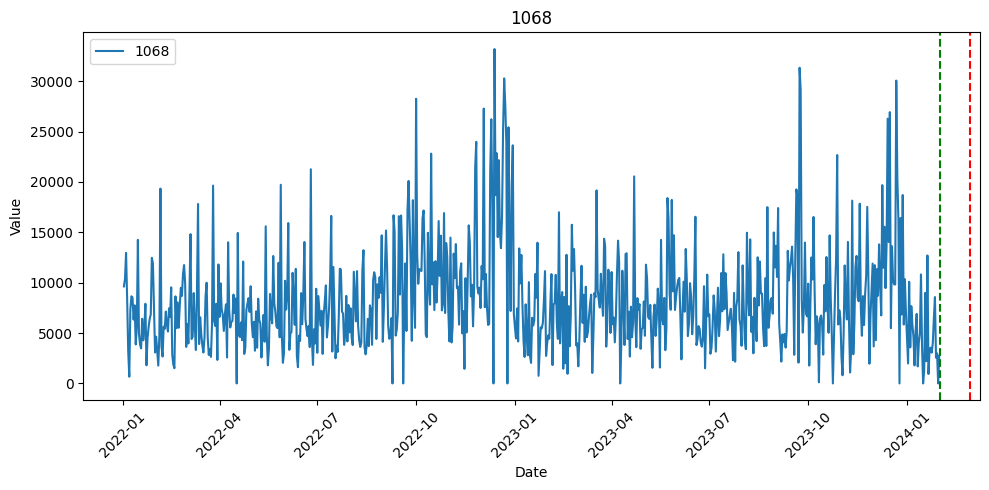

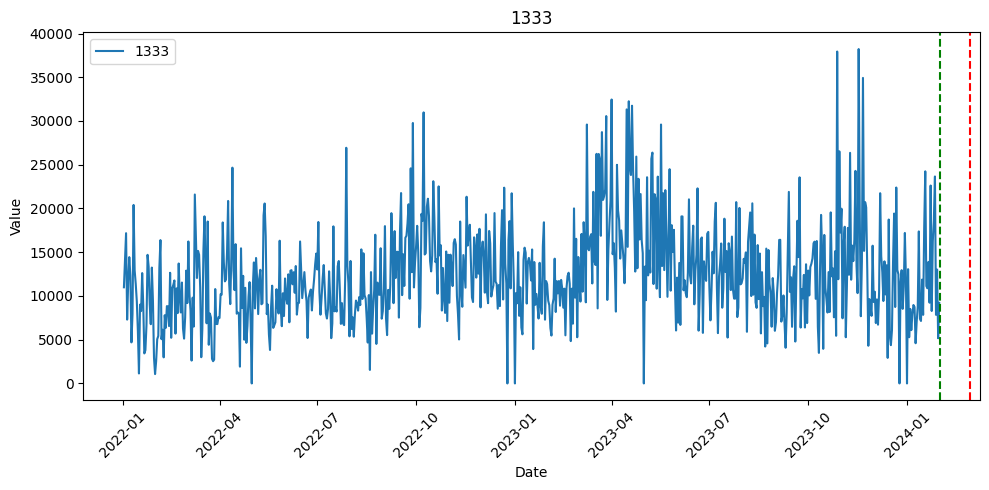

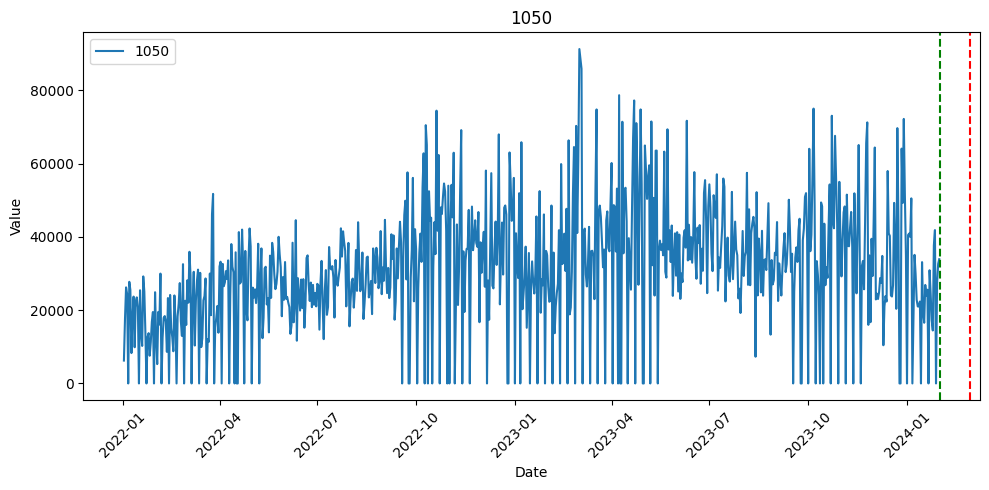

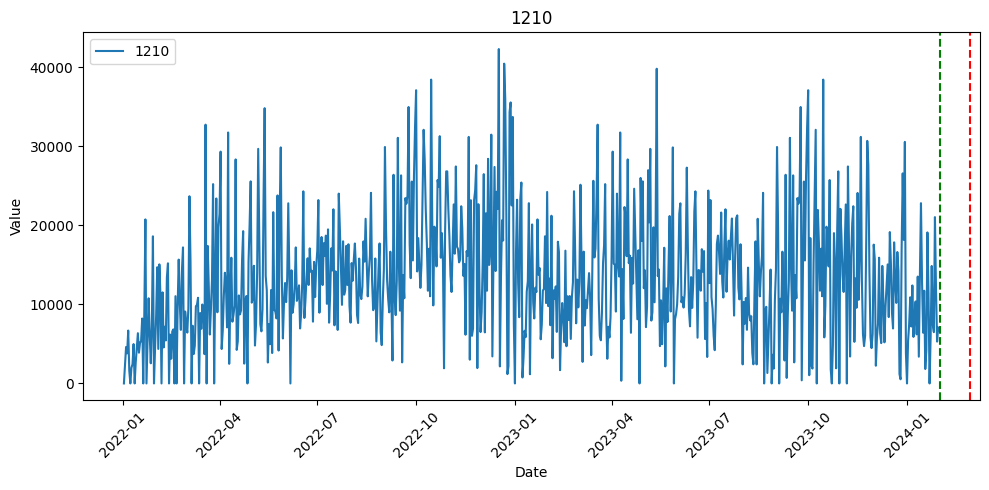

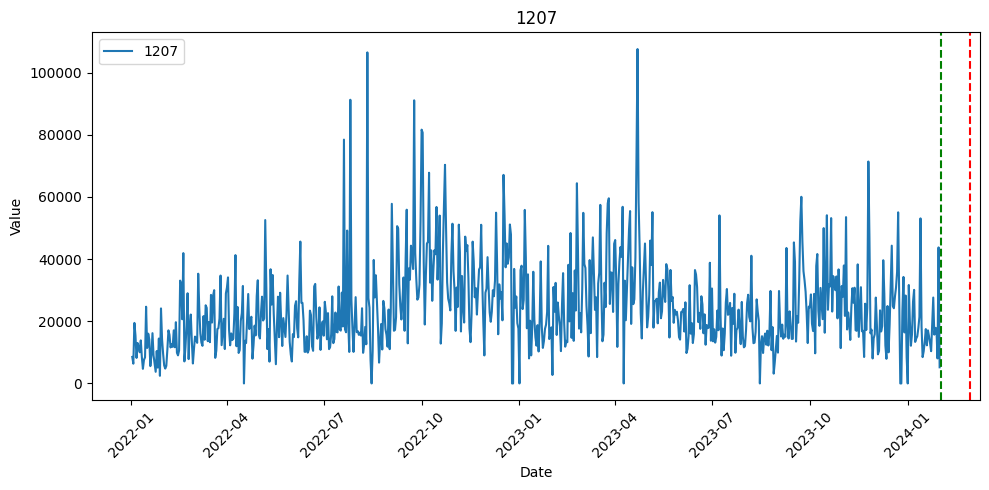

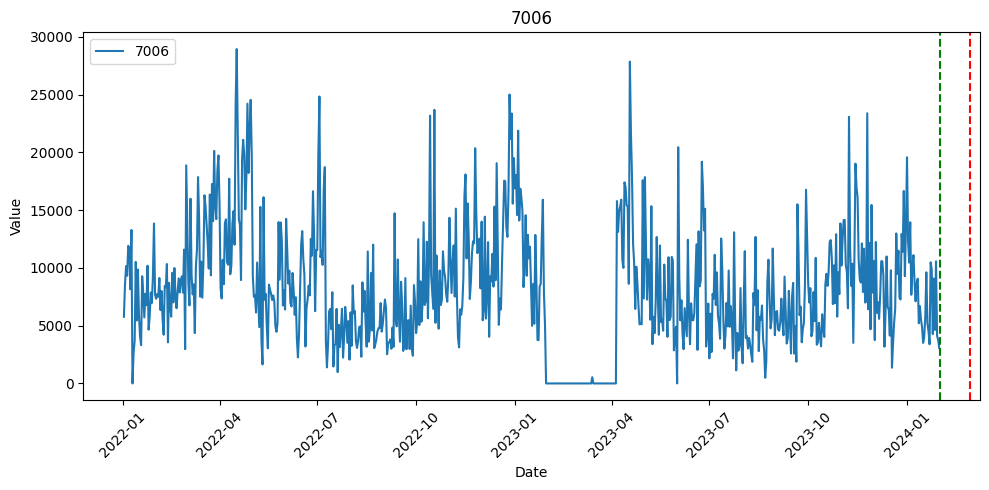

In [0]:
control_stores = train_data[added_stores+["ds"]]
a = date(2022, 1, 1)
filt_control_data = control_stores.query("ds > @a")

for control_store in added_stores:
    plt.figure(figsize=(10, 5))
    plt.plot(filt_control_data["ds"], filt_control_data[control_store], label=control_store)
    #plt.plot(filt_control_data["ds"], filt_control_data["Agg_Pilot_Stores"], label="Agg_Pilot_Stores")
    plt.title(control_store)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.axvline(get_test_start, color='green', linestyle='--', label=str(get_test_start))
    plt.axvline(get_test_end, color='red', linestyle='--', label=str(get_test_end))
    plt.tight_layout()
    plt.show()

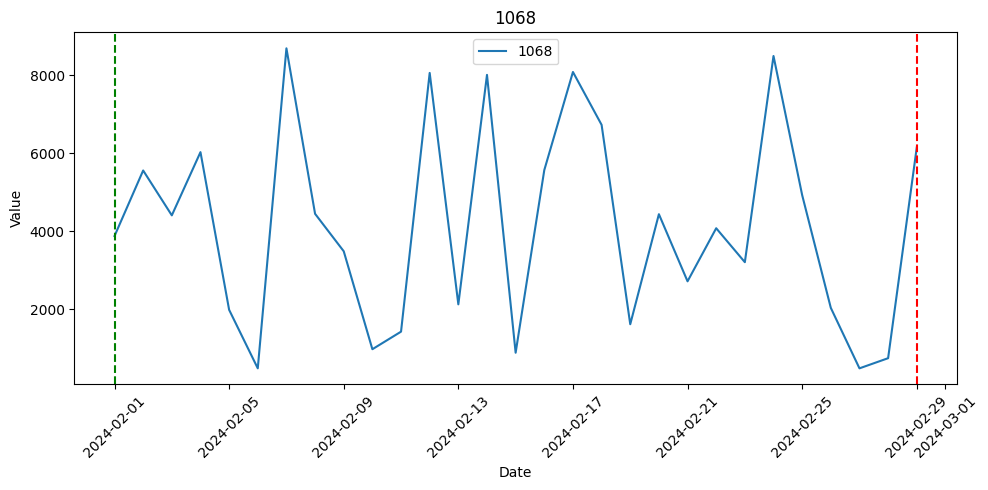

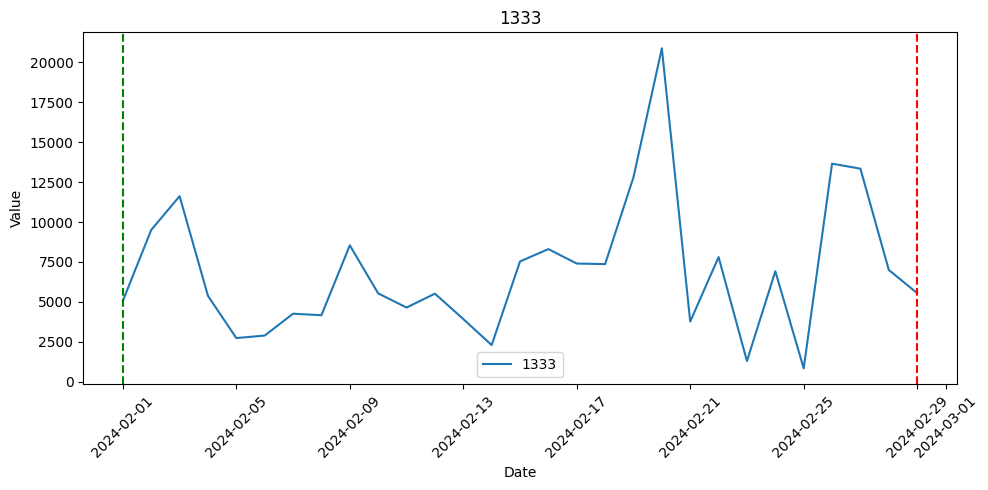

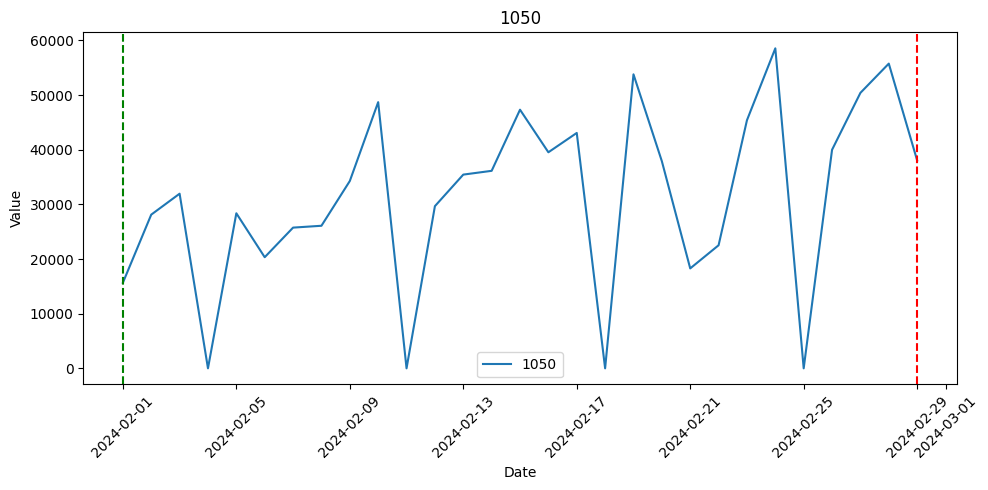

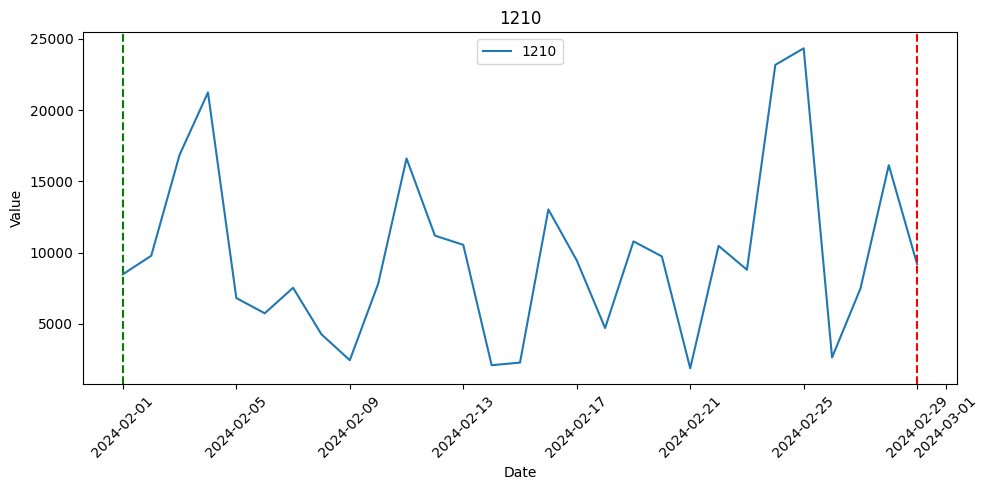

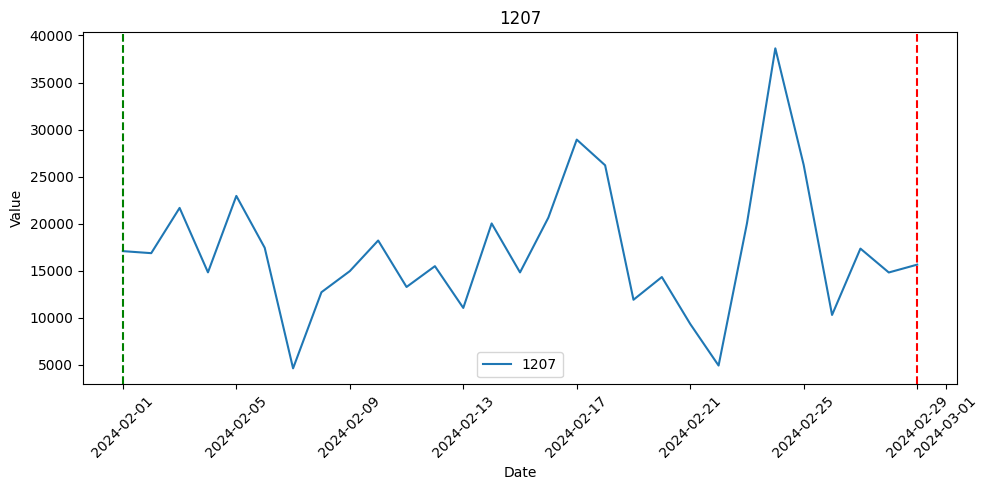

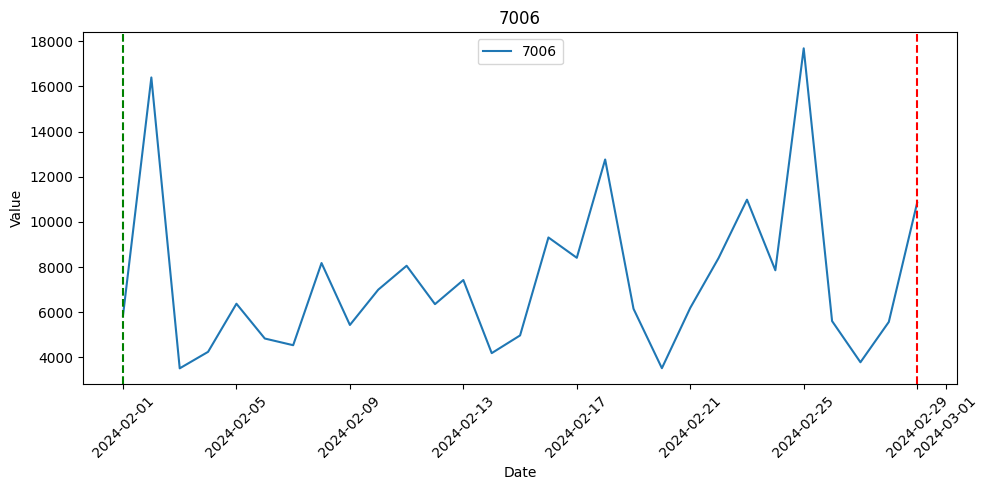

In [0]:
control_stores = X_test[added_stores+[get_date_column]]

for control_store in added_stores:
    plt.figure(figsize=(10, 5))
    plt.plot(control_stores[get_date_column], control_stores[control_store], label=control_store)
    #plt.plot(filt_control_data["ds"], filt_control_data["Agg_Pilot_Stores"], label="Agg_Pilot_Stores")
    plt.title(control_store)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.axvline(get_test_start, color='green', linestyle='--', label=str(get_test_start))
    plt.axvline(get_test_end, color='red', linestyle='--', label=str(get_test_end))
    plt.tight_layout()
    plt.show()